In [2]:
import pandas as pd
import numpy as np

import sympy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import statsmodels.api as sm
from linearmodels.panel import RandomEffects

from statsmodels.regression.mixed_linear_model import MixedLM
from linearmodels.panel import PanelOLS
from scipy.stats import chi2
from scipy.stats import linregress

import plotly.graph_objects as go
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geoviews



In [3]:
raw = pd.read_excel(r"Data\mydata.xlsx", sheet_name="Sheet1")
df=raw[raw['previouscode']>0].copy()
df.reset_index(drop=True, inplace=True)

In [4]:
# coord[coord['consumernumber']==7571][['longitude']]

In [4]:
coord = pd.read_excel(r"Data\coordinates.xlsx")
coord['type'] = 'Moshav'
coord.loc[coord['moshav']==0, 'type'] = 'Kibbutz'
cons_to_omit = coord[(coord['latitude']>32.8) | ((coord['latitude']>32.4) & (coord['longitude']>35.15))]['consumernumber'].unique().tolist()

df = df[~df['consumernumber'].isin(cons_to_omit)].copy()
df = df[df['consumernumber']!=7571].copy()

In [5]:
df['consumertype']='FW'
df.loc[(df['previouscode']>4)&(df['previouscode']<99) , 'consumertype']='FW+S'
df.loc[df['previouscode']>99, 'consumertype']='FW+S+T'

tww_cons = df[df['consumertype']=='FW+S+T']['consumernumber'].unique().tolist()
coord.loc[coord['consumernumber'].isin(tww_cons), 'consumertype'] = 'FW+S+T'

In [6]:
print(f"Data Shape BEFORE consumption filtering: {df.shape}")
df = df[((df['ws']>10) & (df['consumertype']=='FW+S')) | ((df['ws']>10) & (df['consumertype']=='FW+S+T')) | (df['consumertype']=='FW')].copy()
# df = df[df['w1+w2+w3']>20]
df = df[df['w']>50]

print(f"Data Shape AFTER consumption filtering: {df.shape}")

d = df.groupby(by=['consumernumber'], as_index=False).size().sort_values(by='size', ascending=True)
less_than_3 = d[d['size']<3]['consumernumber'].tolist()
df = df[~df['consumernumber'].isin(less_than_3)].copy()

print(f"Data Shape AFTER straight panel filtering: {df.shape}")

#for mapping
consumers_to_consider = df['consumernumber'].unique().tolist()

Data Shape BEFORE consumption filtering: (1818, 76)
Data Shape AFTER consumption filtering: (1620, 76)
Data Shape AFTER straight panel filtering: (1606, 76)


In [7]:
# d = df_map.merge(df[['consumernumber','totalvillagesland']], how='left', on='consumernumber')

# d.dropduplicates(subset=['consumernumber'], keep='last', inplace=True)

### Plot 1 : 
#### Map of the Shafdan Consumer Sample (Kibbutzim and Moshavim)

C:\Users\saarp\AppData\Local\Temp\ipykernel_13160\68360683.py:31: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  gdf.plot(ax=ax, column='Group', color=gdf['Group'].map(color), legend=True, markersize= 18, alpha=0.7)


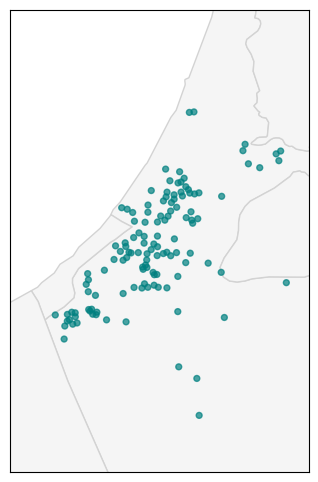

In [8]:
def shafd_map_func(df, var, color1 = 'teal',color2 = 'darkslategray', zoom = 1):

    df = df[df['consumertype']!= 'FW'].copy()

    # Calculate map boundaries
    min_lng = df['longitude'].min() - 0.2 * zoom
    max_lng = df['longitude'].max() + 0.1 * zoom
    min_lat = df['latitude'].min() - 0.25 * zoom
    max_lat = df['latitude'].max() + 0.45 * zoom

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
    world = gpd.read_file(r"Data\isr mapping\ne_10m_admin_0_countries_isr.shp")
    l = df[var].unique().tolist()

    # Group categories into Group 1 and Group 2
    g1 = 'Shafdan'
    g2 = 'Shafdan + Tww'

    gdf['Group'] = gdf[var].apply(lambda x: 'Group 1' if x == l[0] else 'Group 2')

    # Set up color mapping for the two groups
    color = {'Group 1': color1, 'Group 2': color1}

    # Plot world map
    fig, ax = plt.subplots(figsize=(15, 6))
    world.plot(ax=ax, color='whitesmoke', edgecolor='lightgray')

    # Plot grouped data with colors
    gdf.plot(ax=ax, column='Group', color=gdf['Group'].map(color), legend=True, markersize= 18, alpha=0.7)

    # Create a legend for the two groups
    # legend_elements = [
    #     Line2D([0], [0], marker='o', color='w', markerfacecolor=color1, markersize=10, label=g1),
    #     Line2D([0], [0], marker='o', color='w', markerfacecolor=color2, markersize=10, label=g2)
    # ]
    # ax.legend(handles=legend_elements, loc='upper left', fontsize=11)


    # Adjust plot limits
    ax.set_xlim([min_lng, max_lng])  # Set x-axis
    ax.set_ylim([min_lat, max_lat])  # Set y-axis

    # Add title
    # ax.set_title(f"136 Shafdan's Consumers", fontdict={'fontsize': 15}, pad=20)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Show the plot
    plt.show()


df_map = coord[coord['consumernumber'].isin(consumers_to_consider)].copy()
shafd_map_func(df_map,'consumertype',
               color1 = 'teal',color2 = 'darkslategray', zoom = 0.8
              )

### Plot 2 : 
#### Goodness of Fit - Predictive Model

In [32]:
def tarrifs_variables_and_cleaning(df,weight_for_july = 1, shafdan_weight_for_july = 1, type = 'r'):


    nominal_winter_tariff_pf1 = {2015:2.364,2016:2.506,2017:2.506,2018:1.98,2019:2.007,2020:1.841,2021:1.852,2022:1.877}
    nominal_winter_tariff_pf2 = {2015:2.6,2016:2.757,2017:2.757,2018:2.772,2019:3.3,2020:3.294,2021:3.314,2022:3.375}
    nominal_winter_tariff_pf3 = {2015:6.043,2016:5.566,2017:5.385,2018:5.214,2019:5.708,2020:6.09,2021:6.025,2022:4.806}
    nominal_winter_tariff_ps = {2015:1.11,2016:1.094,2017:1.094,2018:1.102,2019:1.116,2020:1.337,2021:1.416,2022:1.448}

    nominal_summer_tariff_pf1 = {2015:2.34,2016:2.5,2017:1.937,2018:1.998,2019:1.94,2020:1.856,2021:1.861,2022:1.94}
    nominal_summer_tariff_pf2 = {2015:2.574,2016:2.75,2017:2.772,2018:2.797,2019:3.3,2020:3.321,2021:3.347,2022:3.489}
    nominal_summer_tariff_pf3 = {2015:5.983,2016:5.553,2017:5.214,2018:5.291,2019:5.708,2020:6.071,2021:4.936,2022:4.886}
    nominal_summer_tariff_ps = {2015:1.099,2016:1.091,2017:1.104,2018:1.112,2019:1.25,2020:1.348,2021:1.43,2022:1.538}

    ## מדד מחירי גידולי השדה - בסיס 2022 המרה שעשיתי לבד 
    tfuka_d = {2022:1,
            2021:0.9846293,
            2020:0.977396,
            2019:0.9566,
            2018:0.964738,
            2017:0.904159,
            2016:0.924566,
            2015:0.865963}
    
    df['p_f1_norm_jul'] = df['year'].map(nominal_summer_tariff_pf1)*df['year'].map(tfuka_d)
    df['p_f2_norm_jul'] = df['year'].map(nominal_summer_tariff_pf2)*df['year'].map(tfuka_d)
    df['p_f3_norm_jul'] = df['year'].map(nominal_summer_tariff_pf3)*df['year'].map(tfuka_d)
    df['p_s_norm_jul'] = df['year'].map(nominal_summer_tariff_ps)*df['year'].map(tfuka_d)

    df['p_f1_norm_jan'] = df['year'].map(nominal_winter_tariff_pf1)*df['year'].map(tfuka_d)
    df['p_f2_norm_jan'] = df['year'].map(nominal_winter_tariff_pf2)*df['year'].map(tfuka_d)
    df['p_f3_norm_jan'] = df['year'].map(nominal_winter_tariff_pf3)*df['year'].map(tfuka_d)
    df['p_s_norm_jan'] = df['year'].map(nominal_winter_tariff_ps)*df['year'].map(tfuka_d)

    df['pf1_num_jul'] = df['year'].map(nominal_summer_tariff_pf1)
    df['pf2_num_jul'] = df['year'].map(nominal_summer_tariff_pf2)
    df['pf3_num_jul'] = df['year'].map(nominal_summer_tariff_pf3)
    df['ps_num_jul'] = df['year'].map(nominal_summer_tariff_ps)

    df['pf1_num_jan'] = df['year'].map(nominal_winter_tariff_pf1)
    df['pf2_num_jan'] = df['year'].map(nominal_winter_tariff_pf2)
    df['pf3_num_jan'] = df['year'].map(nominal_winter_tariff_pf3)
    df['ps_num_jan'] = df['year'].map(nominal_winter_tariff_ps)


    # df['consumertype']='FW'
    # df.loc[df['previouscode']>4 , 'consumertype']='FW+S'
    df['shafdan_access'] = df['indication_var']
    df['tikun'] = np.where(df['year'] > 2017, 1, 0)
    df['tww_access'] = np.where(df['previouscode'] > 99, 1, 0)
    df['tikun_shafdan'] = df['tikun'] * df['shafdan_access']


    df['Preseason Perc (April-May)'] = df['AprilPercp'] + df['MayPercp']
    df['Postseason Perc (September-October)'] = df['SeptemberPercp'] + df['OctoberPercp']
    df['Season Avg Temp (May-Sept)'] = (df['MayTemp'] + df['JuneTemp'] + df['JulyTemp'] + df['AugustTemp'] + df['SeptemberTemp'])/5


    df['shafdan_blended_consumption'] = df['s_consumtion']
    df['shafdan_blended_consumption'] = df['shafdan_blended_consumption'].fillna(0)

    d_trend ={2015:0,2016:1,2017:2,2018:3,2019:4,2020:5,2021:6,2022:7}
    df['trend'] = df['year'].map(d_trend)

    if type == 'r':
        df['pf1'] = df['pf1_jul'] * weight_for_july + df['pf1_jan'] * (1 - weight_for_july)
        df['pf2'] = df['pf2_jul'] * weight_for_july + df['pf2_jan'] * (1 - weight_for_july)
        df['pf3'] = df['pf3_jul'] * weight_for_july + df['pf3_jan'] * (1 - weight_for_july)
        df['ps'] = df['ps_jul'] * shafdan_weight_for_july + df['ps_jan'] * (1 - shafdan_weight_for_july)
        
    elif type == 'n':

        df['pf1'] = df['pf1_num_jul'] * weight_for_july + df['pf1_num_jan'] * (1 - weight_for_july)
        df['pf2'] = df['pf2_num_jul'] * weight_for_july + df['pf2_num_jan'] * (1 - weight_for_july)
        df['pf3'] = df['pf3_num_jul'] * weight_for_july + df['pf3_num_jan'] * (1 - weight_for_july)
        df['ps'] = df['ps_num_jul'] * shafdan_weight_for_july + df['ps_num_jan'] * (1 - shafdan_weight_for_july)

    elif type == 'norm':

        df['pf1'] = df['p_f1_norm_jul'] * weight_for_july + df['p_f1_norm_jan'] * (1 - weight_for_july)
        df['pf2'] = df['p_f2_norm_jul'] * weight_for_july + df['p_f2_norm_jan'] * (1 - weight_for_july)
        df['pf3'] = df['p_f3_norm_jul'] * weight_for_july + df['p_f3_norm_jan'] * (1 - weight_for_july)
        df['ps'] = df['p_s_norm_jul'] * shafdan_weight_for_july + df['p_s_norm_jan'] * (1 - shafdan_weight_for_july)

        
    else:
        print('wrong type')

    
    df['FWBS1'] = (df['pf2'] - df['pf1']) * (df['q1'])
    df['FWBS2'] = (df['pf2'] - df['pf1']) * (df['q1']) + (df['pf3'] - df['pf2']) * (df['q1'] + df['q2'])

    df['sqr_dps'] = (df['ps'] - df['pf1']) ** 2
    df['qs_dFWBS'] = df['quota_s'] * (df['FWBS1'] - df['FWBS2'])

    df['BS1_tag'] = (df['pf1'] - df['ps']) * df['quota_s'] + (df['pf2'] - df['pf1']) * (df['q1']+df['quota_s'])
    df['BS2_tag'] = (df['pf1'] - df['ps']) * df['quota_s'] + (df['pf2'] - df['pf1']) * (df['q1']+df['quota_s']) + (df['pf3'] - df['pf2']) * (df['quota_s'] + df['q1'] + df['q2'])

    df['q_delta_BS_fw'] = (df['q1']) * (df['BS1_tag'] - df['BS2_tag'])
    df['S x FWBS2'] = df['shafdan_access'] * df['FWBS2']


    df_clean=df[['year', 'consumernumber', 'consumertype','name',
                  'w','w1','w2','w3', 'ws', 'q2', 'pf1', 'pf2', 'pf3', 'w1+w2+w3', 'quota_s','quota_t','q1','ps',
                  'shafdan_access','shafdan_blended_consumption',
                  'Preseason Perc (April-May)','Postseason Perc (September-October)','Season Avg Temp (May-Sept)',
                  'totalvillagesland','tww_access','tikun','trend',

                  'FWBS1', 'FWBS2', 'sqr_dps', 'qs_dFWBS',
                    'BS1_tag', 'BS2_tag', 'q_delta_BS_fw', 'S x FWBS2'

                    ]].dropna()

               


    return df_clean


mydata = tarrifs_variables_and_cleaning(df,0.5,0.5, "norm")
print(f"The Shape of mydata is: {mydata.shape}")
print(f"The Shape of mydata_s is: {mydata[mydata['consumertype']!='FW'].shape}")


The Shape of mydata is: (1567, 35)
The Shape of mydata_s is: (951, 35)


In [60]:
s_base_exog_vars = ['ps','quota_s']
s_expelantories = ['Season Avg Temp (May-Sept)','Preseason Perc (April-May)','Postseason Perc (September-October)','trend','quota_t']
additional_vars_list = ['FWBS1','sqr_dps', 'qs_dFWBS']

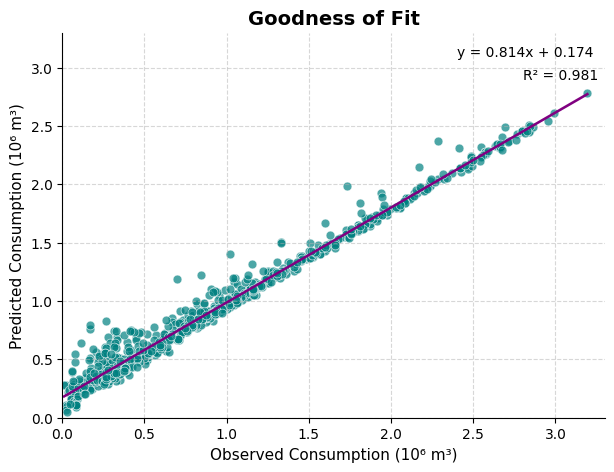

In [61]:
def plot_regression_fit_from_panel(df,
                                   s_base_exog_vars,
                                   s_expelantories,
                                   additional_vars_list,
                                   y_col='ws',
                                   consumer_filter='FW',
                                   x_label='Observed Consumption (10⁶ m³)',
                                   y_label='Predicted Consumption (10⁶ m³)',
                                   title='Goodness of Fit',
                                   xlim=(0, 3.3), ylim=(0, 3.3),
                                   annotation_coords=((2.8, 2.9), (2.4, 3.1))):

    mydata_s = df[df['consumertype'] != consumer_filter]
    my_df2 = mydata_s.set_index(['consumernumber', 'year'])

    Y = my_df2[y_col]
    X = my_df2[s_base_exog_vars + additional_vars_list + [var for var in s_expelantories if var != 'shafdan_access']]
    X = sm.add_constant(X)

    s_mod_fe = PanelOLS(Y, X, entity_effects=True)
    s_results = s_mod_fe.fit(cov_type='clustered', cluster_entity=True)

    my_df2['predicted_ws'] = s_results.predict(X)
    my_df2 = my_df2.dropna(subset=['ws', 'predicted_ws'])

    plot_data = my_df2[[y_col, 'predicted_ws']].reset_index(drop=True)
    plot_data['ws_observed_in_milions'] = plot_data[y_col] / 1000
    plot_data['ws_expected_in_milions'] = plot_data['predicted_ws'] / 1000

    slope, intercept, r_value, _, _ = linregress(plot_data['ws_observed_in_milions'], plot_data['ws_expected_in_milions'])
    r_squared = r_value ** 2

    plt.figure(figsize=(7, 5))
    sns.scatterplot(data=plot_data, x='ws_observed_in_milions', y='ws_expected_in_milions', color='teal', s=40, alpha=0.7)
    sns.regplot(data=plot_data, x='ws_observed_in_milions', y='ws_expected_in_milions', scatter=False, color='purple', line_kws={'linewidth': 1.8})

    plt.text(*annotation_coords[0], f'R² = {r_squared:.3f}', color='black')
    equation_text = f'y = {slope:.3f}x + {intercept:.3f}'
    plt.text(*annotation_coords[1], equation_text, color='black')

    plt.xlabel(x_label, fontsize=11)
    plt.ylabel(y_label, fontsize=11)
    plt.title(title, fontsize=14, fontweight='bold')

    plt.xlim(*xlim)
    plt.ylim(*ylim)

    sns.despine()
    plt.grid(True, which='major', linestyle='--', alpha=0.5)
    plt.ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
    plt.show()

plot_regression_fit_from_panel(
    df=mydata,
    s_base_exog_vars=s_base_exog_vars,
    s_expelantories=s_expelantories,
    additional_vars_list=additional_vars_list,
    y_col='ws',
    consumer_filter='FW',
    x_label='Observed Consumption (10⁶ m³)',
    y_label='Predicted Consumption (10⁶ m³)',
    title='Goodness of Fit',
    xlim=(0, 3.3),
    ylim=(0, 3.3),
    annotation_coords=((2.8, 2.9), (2.4, 3.1))
)

### Plot 3 : 
#### Aggregate Demand for Shafdan Under Fresh Irrigation Water Pricing Scheme Scenarios

In [62]:
specific_coeff_vector = [-1454.396,
                0.819,-0.0344,
                -1.052,1.038,61.623,
                16.389]

mydata_s_2020 = mydata[(mydata['year'] == 2020) & (mydata['consumertype'] != 'FW')].copy()


preperc = mydata_s_2020['Preseason Perc (April-May)'].mean()
seaperc = mydata_s_2020['Postseason Perc (September-October)'].mean()
temp = mydata_s_2020['Season Avg Temp (May-Sept)'].mean()
trend = mydata_s_2020['trend'].mean()
quota_s = mydata_s_2020['quota_s'].mean()
quota_t = mydata_s_2020['quota_t'].mean()

controlled_param = [quota_s, quota_t, preperc, seaperc, temp, trend]
myconst = np.dot(specific_coeff_vector[1:], controlled_param) + specific_coeff_vector[0]
#-103.088,
#-0.021,
#48.952
ps_array = np.arange(0.8, 3.02, 0.02)
pf1_array = np.arange(1.5, 3.02, 0.02)

val_list = []
for ps in ps_array:
    for pf1 in pf1_array:
        if ps <= pf1:
            q1dpf = mydata_s_2020['q1'].mean()*(3.1-pf1)
            price_impact = -103.088*ps -0.021*q1dpf + 48.952*(pf1-ps)**2
            consumption = myconst + price_impact
            l = [ps, pf1, consumption]
            
        # else:
        #     consumption = 0
        #     l = [ps, pf1, consumption]
        val_list.append(l)

prices_scenarios = pd.DataFrame(val_list, columns=['ps', 'pf1', 's_cons'])
prices_scenarios['Total Consumption (MCM)'] = prices_scenarios['s_cons'] * raw[raw['previouscode']>4]['consumernumber'].nunique() / 1000

In [102]:
val_list1=[]
pf1_senarios = [1.81, 1.4, 2.2]
ps_array1 = np.arange(0.75, 2.5, 0.01)
for ps in ps_array1:
    l=[]
    for pf1 in pf1_senarios:
        if ps <= pf1:
            q1dpf = mydata_s_2020['q1'].mean()*(3.5-pf1)
            price_impact = -103.088*ps -0.021*q1dpf + 48.952*(pf1-ps)**2
            consumption = (myconst + price_impact) * raw[raw['previouscode']>4]['consumernumber'].nunique() / 1000
            l.append(consumption)
        else:
            l.append(np.nan)
    val_list1.append(l)

prices_scenarios1 = pd.DataFrame(val_list1, columns=['Pfw = 1.81', 'Pfw = 1.40', 'Pfw = 2.20'])
prices_scenarios1['ps'] = ps_array1

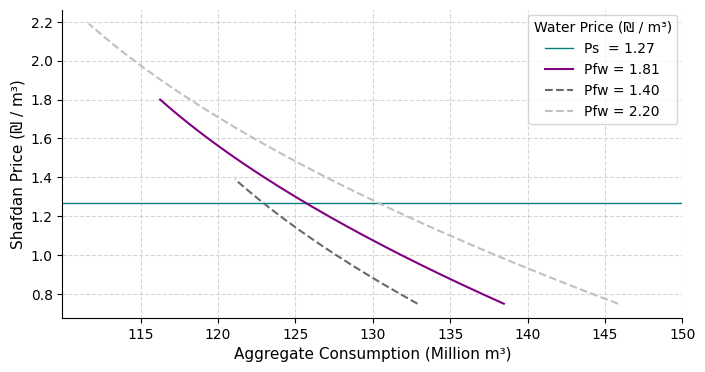

In [104]:
plt.style.use('default')
purple_shades = ['purple', 'dimgray' , 'silver']
fig, ax = plt.subplots(figsize=(8, 4))

shafdan_price = ((raw[raw['year']==2020]['ps_jul'].mean() + raw[raw['year']==2020]['ps_jan'].mean())/2).round(2)
ax.axhline(y=shafdan_price, color='teal', linewidth=1, alpha=1, label = f'Ps  = {shafdan_price:.2f}')

for i, col in enumerate(prices_scenarios1.columns[:-1]):
    # i want to add condition that if col!="2.0" than the line would be "---" and else full line
    if col == 'Pfw = 1.81':
        ax.plot( prices_scenarios1[col],prices_scenarios1['ps'], label=col, color=purple_shades[i])
    else:
        ax.plot( prices_scenarios1[col],prices_scenarios1['ps'], label=col, color=purple_shades[i], linestyle='--')

xlab1 = 'Aggregate Consumption (Million m³)'
ylab1 = 'Shafdan Price (₪ / m³)'
ax.set_xlabel(xlab1, fontsize=11)
ax.set_ylabel(ylab1, fontsize=11)

leg1 = 'Water Price (₪ / m³)'
ax.legend(title= leg1, loc='upper left', bbox_to_anchor=(0.74, 1.005))
xticks = np.arange(115, 155, 5)
ax.set_xticks(xticks)



# Show plot
sns.despine()
plt.grid(True, which='major', linestyle='--', alpha=0.5)
plt.show()